# Setup

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade
!pip install 'sagemaker>=2,<3'

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 9.2.0
    Uninstalling Pillow-9.2.0:
      Successfully uninstalled Pillow-9.2.0
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Using cached PyYAML-6.0-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (701 kB)
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 5.4.1
    Uninstalling PyYAML-5.4.1:
      Successfully uninstalled PyYAML-5.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.157 requires PyYAML<5.5,>=3.10, but y

In [2]:
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::782138889654:role/service-role/AmazonSageMaker-ExecutionRole-20230705T220639


In [3]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3

from tqdm import tqdm
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.


# Visualize Data

In [4]:
trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [5]:
image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [6]:
images[0]

'Siamese_52.jpg'

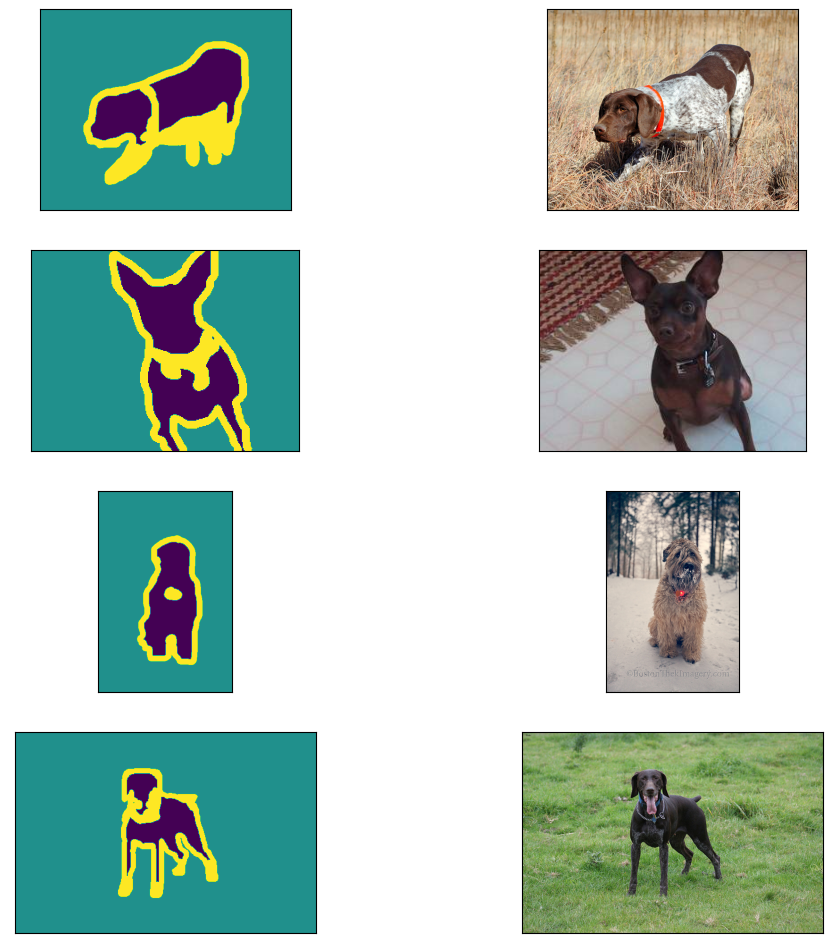

In [7]:
plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [8]:
img = Image.open(os.path.join(trimaps_dir, maps[0]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [9]:
bucket_name = 'semanticpets2023'
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)

print(training_image)

825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [11]:
def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:05<00:00, 1435.55it/s]


In [12]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [13]:
print(len(train_annots), len(train_images))

5522 5522


# Uploading Data to S3

In [14]:
%%time
sess = sagemaker.Session()

print('Starting upload..')
s3_train_path = sess.upload_data(path='train', bucket=bucket_name, key_prefix='train')
print('Training images uploaded')
s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                     key_prefix='train_annotation')
print('Training Annotations uploaded')
s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name,
                                      key_prefix='validation')
print('Validation images uploaded')
s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name,
                                          key_prefix='validation_annotation')
print('Validation Annotations uploaded')

Starting upload..
Training images uploaded
Training Annotations uploaded
Validation images uploaded
Validation Annotations uploaded
CPU times: user 1min 28s, sys: 8.4 s, total: 1min 36s
Wall time: 17min 5s


In [15]:
s3_validation_annotation_path

's3://semanticpets2023/validation_annotation'

# SageMaker Estimator

In [16]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    instance_count=1,
    instance_type='ml.p3.2xlarge',
    volume_size=100,
    max_run=36000,
    input_mode='File',
    output_path='s3://semanticpets2023/output',
    sagemaker_session=sess
)

# Hyperparameters

In [17]:
model.set_hyperparameters(
    backbone='resnet-50', 
    algorithm='fcn',                            
    use_pretrained_model='True', 
    crop_size=240,                             
    num_classes=4, 
    epochs=10, 
    learning_rate=0.0001,                             
    optimizer='rmsprop', 
    lr_scheduler='poly',                            
    mini_batch_size=16, 
    validation_mini_batch_size=16,
    early_stopping=True, 
    early_stopping_patience=3, 
    early_stopping_min_epochs=10,                              
    num_training_samples=len(train_images)
)

# Data Channels

In [18]:
train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')
validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated',
                          content_type='image/jpeg', s3_data_type='S3Prefix')

train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated',
                          content_type='image/png', s3_data_type='S3Prefix')

In [19]:
data_channels = {
    'train': train_data,
    'train_annotation': train_annotation_data,
    'validation': validation_data,
    'validation_annotation': validation_annotation_data
}

# Training the model

In [20]:
model.fit(inputs=data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2023-07-06-01-46-08-872


2023-07-06 01:46:09 Starting - Starting the training job...
2023-07-06 01:46:33 Starting - Preparing the instances for training......
2023-07-06 01:47:35 Downloading - Downloading input data...............
2023-07-06 01:49:56 Training - Downloading the training image...............
2023-07-06 01:52:42 Training - Training image download completed. Training in progress.....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Thu Jul  6 01:53:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|     

# Deploying the model

In [21]:
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print('\nModel deployed!')

INFO:sagemaker:Creating model with name: semantic-segmentation-2023-07-06-02-18-05-348
INFO:sagemaker:Creating endpoint-config with name semantic-segmentation-2023-07-06-02-18-05-348
INFO:sagemaker:Creating endpoint with name semantic-segmentation-2023-07-06-02-18-05-348


----------------!
Model deployed!


# Predictions

In [22]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1868


In [23]:
deployed_model.content_type = 'image/jpeg'
deployed_model.accept = 'image/png'

In [36]:
index = 419

image_path = os.path.join(image_dir, images[index])

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

In [37]:
import io

mask = np.array(Image.open(io.BytesIO(results)))

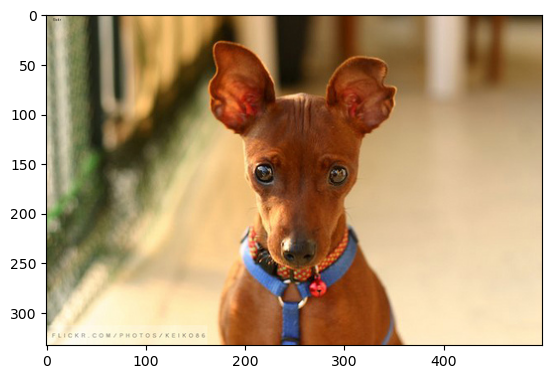

In [38]:
plt.imshow(plt.imread(image_path));

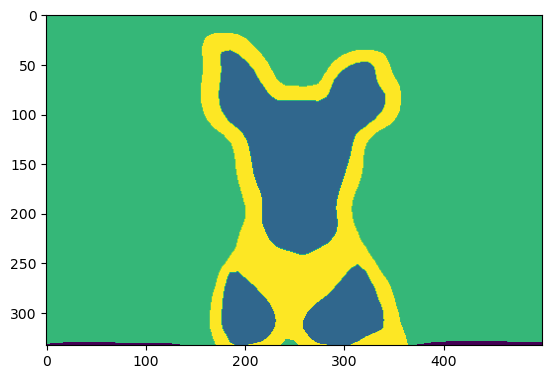

In [39]:
plt.imshow(mask);

# The End: taking the model offline

In [41]:
deployed_model.delete_endpoint()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-2:782138889654:endpoint/semantic-segmentation-2023-07-06-02-18-05-348".

Bye!